파이썬과 Auto ARIMA를 통한 계절성을 지닌 시계열 예측

참고: https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

일련의 사건들이 시간적 요소를 가졌다고 해도, 무작위로 간격을 두고 시계열이 아닌 갑자기 발생하는 요소(사고같은)가 생길 수 가 있음.

시계열은 trend(추세), seasonality(계절성), noise(잡음)이라는 Key 변수들을 가지고 있다.

In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
!pip install pyramid-arima
from pyramid.arima import auto_arima

     |████████████████████████████████| 604kB 2.8MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning:


    The 'pyramid' package will be migrating to a new 

# Forecasting with ARIMA
시계열 분석 방법 중 하나가 ARIMA 모델인데, ARIMA는 AutoRegressive Integrated Moving Average(자기회귀누적이동평균)를 의미한다.

- parameter
 - p : Seasonality
 > p 는 자동조절(auto-regressive)와 관련된 매개변수(parameter)로 과거 값을 통합한다. ex) 과거 며칠동안 비가 내리면? -> "내일 또한 비가 내릴 것이다." 라고 판단
 - d : trend
 > d 는 시계열에 적용할 양의 차이에 영향을 끼치는 모델의 통합된 부분(integrated part)과 관련된 매개변수이다. ex) 지난 며칠 동안 하루 강수량이 비슷했다면 -> "내일 내리는 비의 양이 오늘과 비슷할 것"이라는 예측한다.
 - q : noise
 > q 는 모델의 이동 평균(moving average)와 관련된 매개변수이다.

만약 모델이 계절 요소를 가지고 있다면, seasonal ARIMA(SARIMA)를 사용한다. 우선 다른 요소를 고려하지 않고 y-axis(value)와 x-axis(시점)만 고려해 보자.

입문자들이 흔히 저지르는 실수가 주식 가격이나 스포츠 팀의 경기력과 같은 많은 외부 요인들을 가진 데이터를 ARIMA 모델에 적용하는 것이다. ARIMA는 이러한 주제와 관련된 시계열에는 강력하고 관련성이 있는 도구가 될 수 있지만, CEO가 해고되거나 팀에서 부상당하는 등 외부 요인을 고려하지 않고 단독으로 사용한다면 좋은 결과를 얻지 못할 것이다.

# Variation(변동성)
시계열에서 제일 중요한 요소중 하나는 변동성이다. 변동성은 시계열 데이터에 있는 패턴이다.알려진 기간과 정해진 기간에 걸쳐 반복되는 패턴이 있는 시계열은 계절성이 있다고 한다. 계절성은 데이터에서 주기적으로 반복되는 변동에 대한 일반적인 용어다. 일반적으로, 우리는 변동성을 4가지 범주로 생각한다. (**계절, 주기, 추세 및 불규칙 변동**)

계절 변동성(Season variation)은 수영복 가격이 겨울에는 싸지고 여름에는 비싸지는 것 처럼 연간 변동성(annual in period)으로 정의된다. 순환 변동성(Cyclic variation)은 일별 온도 변화같이 다른 고정된 기간에 발생하는 변동성이다. 계절, 순환 변동성 모두 시계열 데이터의 계절성의 예시이다.

추세(Trends)는 평균 수준의 장기적 변화를 나타내고, 관측치 수와 비례함.

# Practice

In [2]:
import pandas as pd
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/IPG2211A2N.csv',index_col=0)
data.head()

,IPG2211A2N
DATE,
1939-01-01,3.3842
1939-02-01,3.4100
1939-03-01,3.4875
1939-04-01,3.5133
1939-05-01,3.5133


## Processing the data

현재 보이는 Date index는 문자열임. 이를 TimeStamp로 바꾸자.

In [0]:
data.index = pd.to_datetime(data.index)

컬럼명을 바꾸자.

In [0]:
data.columns = ['Energy Production']

In [5]:
data

,Energy Production
DATE,
1939-01-01,3.3842
1939-02-01,3.4100
1939-03-01,3.4875
1939-04-01,3.5133
1939-05-01,3.5133
...,...
2019-12-01,113.0698
2020-01-01,116.0371
2020-02-01,109.6576


cufflinks와 plotly를 사용하여 데이터의 그래프를 그릴 수 있다.

In [6]:
fig = make_subplots()
fig.add_trace(go.Scatter(x=data.index, y=data['Energy Production'], showlegend=False,
                         mode='lines', name="First sample",
                         marker=dict(color="blue")))
fig.update_layout(height=600, width=1200, title_text="Energy Production Jan 1939--April 2020")
fig.show()

## Decomposition (분해)
 상승 추세가 있다. 시계열 분해를 하기위해 statsmodels를 사용할 수있다. 시계열 분해는 **시계열을 여러 성분**으로 분해하는 통계적 작업으로 각각 패턴의 기본 범주 중 하나를 나타낸다. statsmodels를 사용하면 데이터의 추세, 계절 및 잔류 성분(residual components)을 확인할 수 있다.

 추세가 더 선형적이고, 계절성 및 추세 성분이 시간이 지남에 따라 일정해 보일때 가법 모델(additive model)을 사용할 수 있다. 비선형 속도로 증가 할 때는 승법 모델(multipticative model)이 더 적절하다.

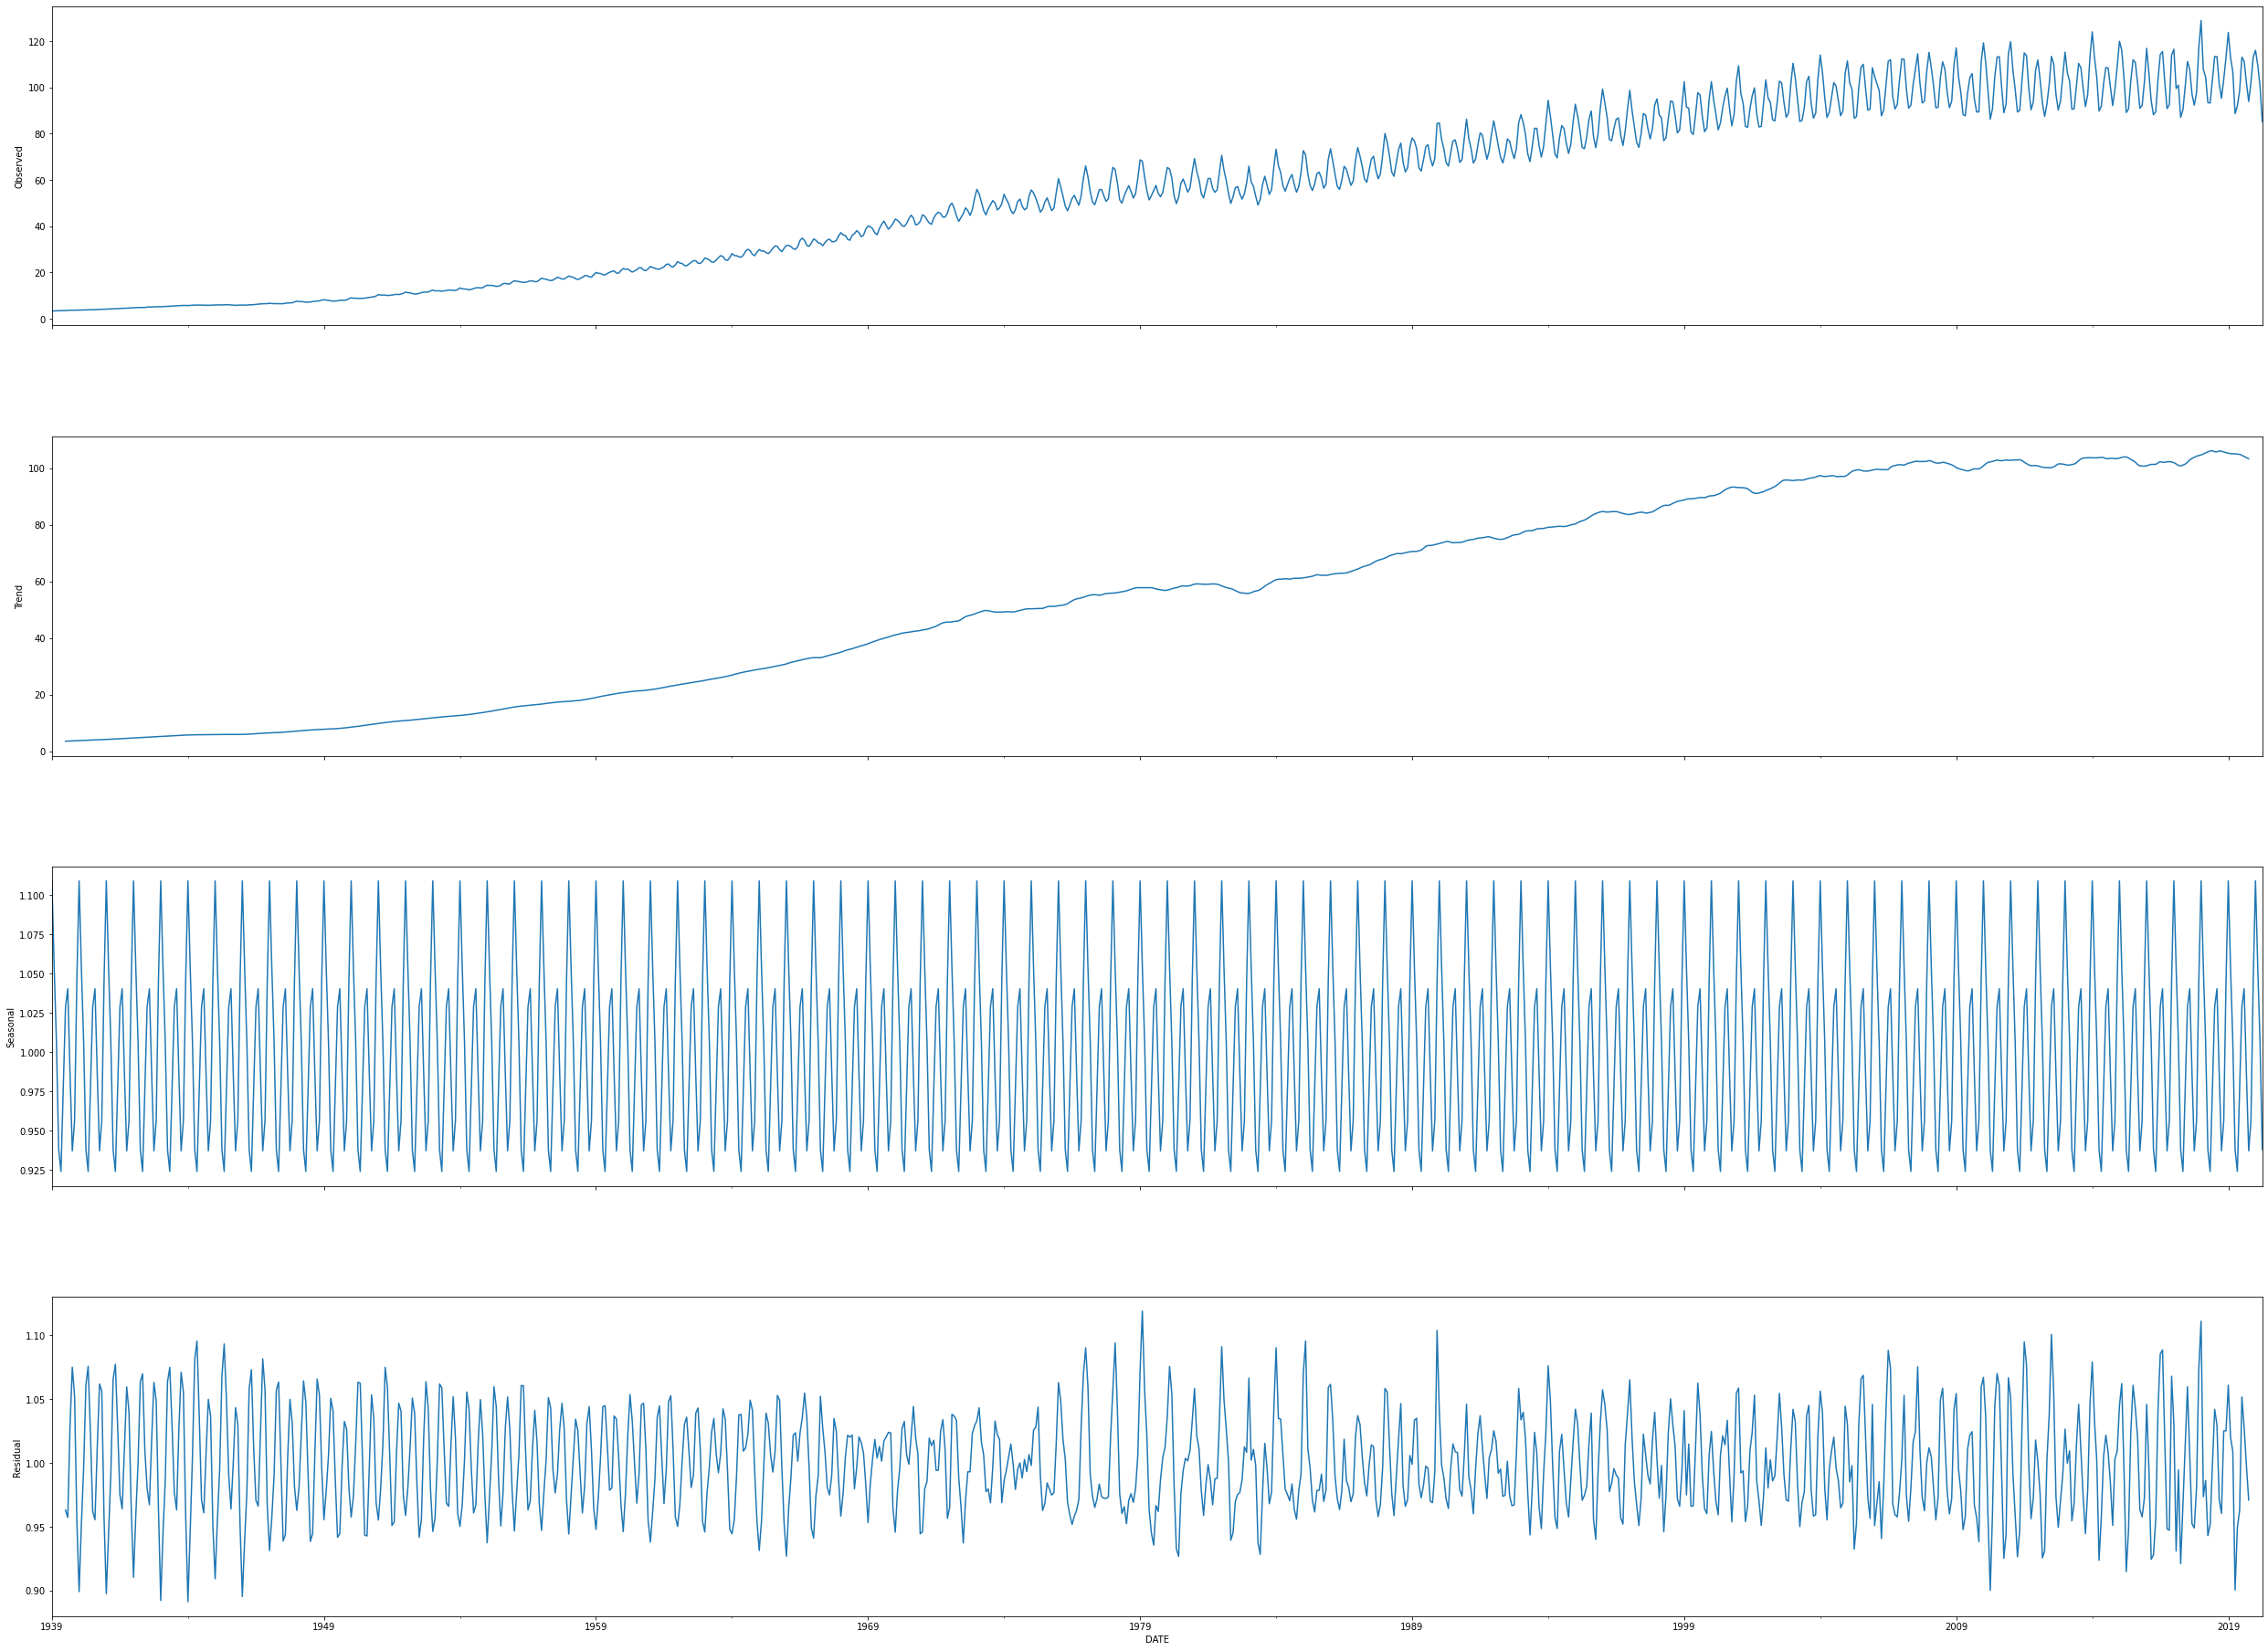

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, model= 'multiplicative')
fig=result.plot()
fig.set_size_inches(40,30)
fig.show()

위 그래프를 보면, 데이터의 계절성이 확실히 보인다. 또한, 데이터의 상향 추세선이 나타남.

추세는 상향이거나 하향일 수도 있고, 선형이거나 비선형일 수도 있다. 상당한 시간이 지났는지의 여부를 알기 위해(실체 추세를 알기 위해) 데이터 셋을 이해하는 것이 중요하다.

불규칙한 변동(Irregular fluctuations)은 무작위적이고 예측할 수 없는 갑작스러운 변화다.

## Performing the Seasonal ARIMA
현재 데이터는 계절 성분을 가지고 있기 때문에 Seasonal ARIMA model을 사용하는 것이 적합하다. 이를 위해서는 ARIMA의 p,d,q 값과 계절 성분의 P,D,Q 값을 선택해야 한다.

이러한 값들을 통계적으로 설정하는 많은 방법이 있다.(auto-correlation plots, correlation plots, domain experience)

한 가지 간단한 접근방식은 일종의 성능 기준을 사용하여 p,d,q,P,D,Q의 여러 값에 걸쳐 Grid Search 수행하는 것이다. Akaike information criterion (AIC)는 주어진 데이터에 대해 통계적 모델의 상대적 품질을 평가하는 것이다. 데이터에 대한 모델 집합이 주어진 경우, AIC는 각 모델 품질을 다른 모델에 비교해 추정한다.

AIC 값을 사용하면 모형이 데이터를 얼마나 잘 적합하는지 비교할 수 있고 모형의 복잡성을 고려할 수 있으므로 특성을 적게 사용하면서 적합도가 더 좋은 모델은 더 많은 특성을 사용하는 유사 모델보다 더 좋은 (낮은) AIC 점수를 받을 수 있다.

Pyramid-arima 라이브러리는 그리드 서치를 신속하게 수행하게 만들어 주고 심지어 훈련 데이터에 맞출 수 있는 모델 객체를 만들 수 있다.



이 라이브러리에는 p,d,q,P,D,Q 값의 범위를 설정하고 가능한 모든 조합에 대해 모델을 맞출 수 있는 auto_arima 함수가 포함되어 있다. 그런 다음 모델은 최상의 AIC 값을 보고한 조합을 선택할 것이다.

In [8]:
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3880.698, BIC=3905.048, Fit time=6.974 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4385.387, BIC=4395.127, Fit time=0.093 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4223.850, BIC=4243.331, Fit time=1.799 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4000.015, BIC=4019.496, Fit time=2.782 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3877.021, BIC=3906.241, Fit time=12.583 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=4060.599, BIC=4084.950, Fit time=5.481 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3866.371, BIC=3900.461, Fit time=30.837 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3986.280, BIC=4015.501, Fit time=13.333 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3864.834, BIC=3903.795, Fit time=38.714 seconds
Fit ARIMA: order=(2, 1, 

최상의 모델은 AIC 3882.569를 기록하고 있음.

In [0]:
# train, test split 
# 80년도 이전의 시계열 생략
train = data.loc['1980-01-01':'2016-12-01']
test = data.loc['2017-01-01':]

In [12]:
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 1, 3),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(2, 1, 2, 12), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend='c')

### Evaluation
train data에 모델이 학습이 됐으면, 미래를 예측할 수 있다. test data는 2017년 1월 1일부터 2020년 4월1일까지다.

In [14]:
test.shape

(40, 1)

In [17]:
future_forecast = stepwise_model.predict(n_periods=40)
print(future_forecast)

[121.91568056 109.81893614 100.11122806  90.22685917  91.76776791
 103.42861471 113.2599934  112.69081872 101.13408032  91.89908085
  95.68713434 111.69503087 120.73433717 110.90772593 101.79020431
  90.46067155  92.26151935 103.35460087 112.90245967 111.84651001
 101.26273797  92.27150892  96.36068416 110.20497339 120.44745828
 111.20880452 101.68865889  90.4002616   92.14507404 103.53459332
 113.09534101 112.2561459  101.75660974  92.35645723  96.12087983
 110.14290553 120.73466085 111.24832095 101.37435074  90.45815094]


In [0]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])

In [43]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=future_forecast.index, y=future_forecast['Prediction'], showlegend=True,
                         mode='lines', name="Prediction",
                         marker=dict(color="blue")))
fig.add_trace(go.Scatter(x=test.index, y= test['Energy Production'], showlegend=True,
                         mode='lines', name="Test",
                         marker=dict(color="red")))
fig.update_layout(height=400, width=600)
fig.show()

In [0]:
kk=pd.concat([data,future_forecast],axis=1)

In [46]:
kk.head()

,Energy Production,Prediction
DATE,,
1939-01-01,3.3842,NaN
1939-02-01,3.4100,NaN
1939-03-01,3.4875,NaN
1939-04-01,3.5133,NaN
1939-05-01,3.5133,NaN


In [47]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=kk.index, y=kk['Energy Production'], showlegend=True,
                         mode='lines', name="Energy Production",
                         marker=dict(color="blue")))
fig.add_trace(go.Scatter(x=kk.index, y= kk['Prediction'], showlegend=True,
                         mode='lines', name="Test",
                         marker=dict(color="red")))
fig.update_layout(height=600, width=1200)
fig.show()